In [1]:
import librosa
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import random
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import torch
import torchmetrics
import os
import warnings
from IPython.display import Audio
warnings.filterwarnings('ignore')
device = torch.device('cpu')

In [2]:
# config
class Config:
    SR = 16000
    N_MFCC = 70
    N_MELS = 70
    # Dataset
    ROOT_FOLDER = './'
    # Training
    N_CLASSES = 2
    BATCH_SIZE = 32
    N_EPOCHS = 15
    LR = 0.0005
    MAX_DURATION = 5 # 최대 시간, 초
    SEED = 42
    PAD_SIZE = MAX_DURATION * SR # 패딩 후 크기 설정 = 샘플 수
    
CONFIG = Config()

In [3]:
def seed_everything(seed):
    import random
    import numpy as np
    import torch

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CONFIG.SEED)

### 데이터 읽기, 데이터 확인 작업

In [4]:
df = pd.read_csv('./train.csv')
X_train, X_val, y_train, y_val = train_test_split(df, df['label'], test_size=0.35, random_state=CONFIG.SEED)

In [29]:
X_train.head()

,index,id,path,label
0,26525,VTGZAXKJ,./train/VTGZAXKJ.ogg,real
1,28922,QLHLSLCS,./train/QLHLSLCS.ogg,fake
2,23673,YKXZZSVS,./train/YKXZZSVS.ogg,real
3,18245,CDLVQGDT,./train/CDLVQGDT.ogg,fake
4,40152,QSHHTXOY,./train/QSHHTXOY.ogg,fake


In [6]:
X_val.head()

,id,path,label
49798,PUOXNOKJ,./train/PUOXNOKJ.ogg,real
54292,GXOIPDJP,./train/GXOIPDJP.ogg,fake
40359,FOEQKPPR,./train/FOEQKPPR.ogg,fake
50441,IYASAVDT,./train/IYASAVDT.ogg,real
37723,VLWIXPTC,./train/VLWIXPTC.ogg,real


In [8]:
y_train.head()

26281    real
34885    real
4455     fake
5795     fake
5264     fake
Name: label, dtype: object

In [9]:
y_val.head()

49798    real
54292    fake
40359    fake
50441    real
37723    real
Name: label, dtype: object

In [5]:
X_train_fake = X_train[X_train["label"]=="fake"]
X_train_real = X_train[X_train["label"]=="real"]

In [6]:
X_train_fake.shape, X_train_real.shape
# fake와 real의 수가 거의 균등함을 알 수 있음

((18005, 3), (18029, 3))

In [7]:
#reset_index를 통해 index를 먼저 초기화해줌
X_train_fake = X_train_fake.reset_index()
X_train_real = X_train_real.reset_index()

In [10]:
X_train_fake.head()

,index,id,path,label
0,28922,QLHLSLCS,./train/QLHLSLCS.ogg,fake
1,18245,CDLVQGDT,./train/CDLVQGDT.ogg,fake
2,40152,QSHHTXOY,./train/QSHHTXOY.ogg,fake
3,54086,XVAYJFQY,./train/XVAYJFQY.ogg,fake
4,18730,YQBNZXBM,./train/YQBNZXBM.ogg,fake


In [11]:
X_train_real.head()

,index,id,path,label
0,26525,VTGZAXKJ,./train/VTGZAXKJ.ogg,real
1,23673,YKXZZSVS,./train/YKXZZSVS.ogg,real
2,12045,JLOOQDFO,./train/JLOOQDFO.ogg,real
3,35415,ZCDJYRLI,./train/ZCDJYRLI.ogg,real
4,13455,OOOYQBGD,./train/OOOYQBGD.ogg,real


### real data 몇 개 확인해보기

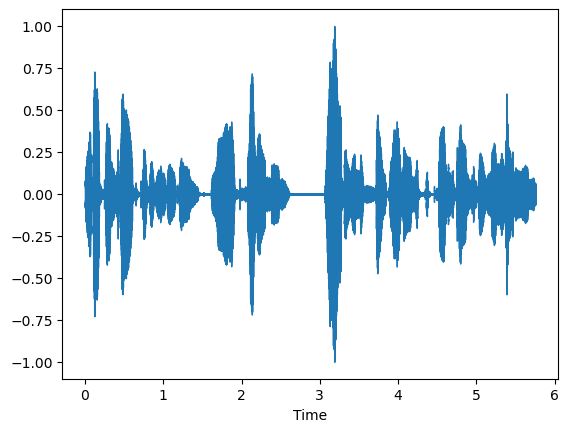

In [178]:
data = os.path.join("./open",X_train_real["path"][0])
audio,sr = librosa.load(data)
audio = librosa.util.normalize(audio)
audiowgt = Audio(data=audio,rate=sr)
display(audiowgt)
librosa.display.waveshow(audio,sr=sr)

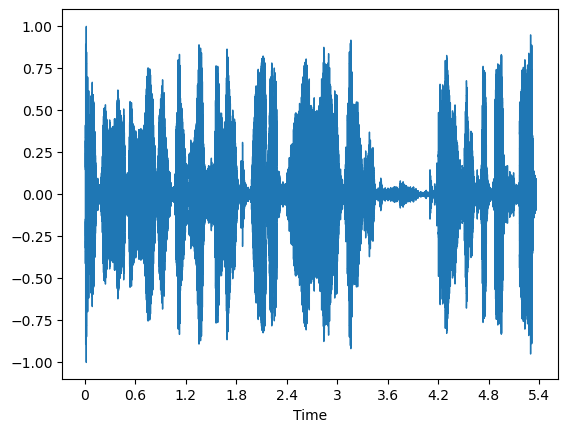

In [180]:
data = os.path.join("./open",X_train_real["path"][1])
audio,sr = librosa.load(data)
audio = librosa.util.normalize(audio)
audiowgt = Audio(data=audio,rate=sr)
display(audiowgt)
librosa.display.waveshow(audio,sr=sr)

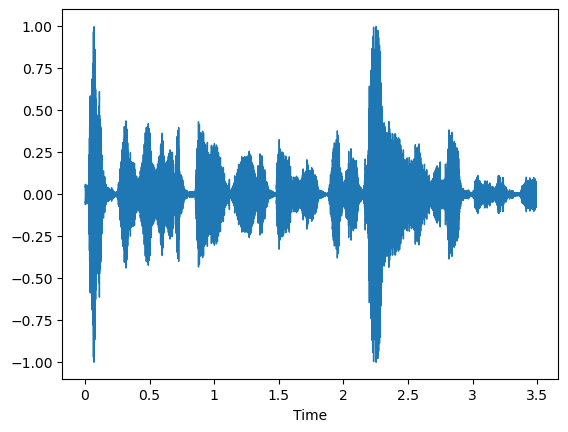

In [181]:
data = os.path.join("./open",X_train_real["path"][2])
audio,sr = librosa.load(data)
audio = librosa.util.normalize(audio)
audiowgt = Audio(data=audio,rate=sr)
display(audiowgt)
librosa.display.waveshow(audio,sr=sr)

### fake 데이터 몇 개 확인해보기

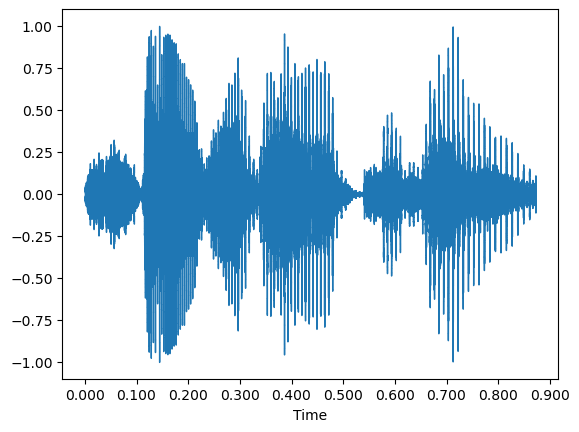

In [185]:
data = os.path.join("./open",X_train_fake["path"][0])
audio,sr = librosa.load(data)
audio = librosa.util.normalize(audio)
audiowgt = Audio(data=audio,rate=sr)
display(audiowgt)
librosa.display.waveshow(audio,sr=sr)

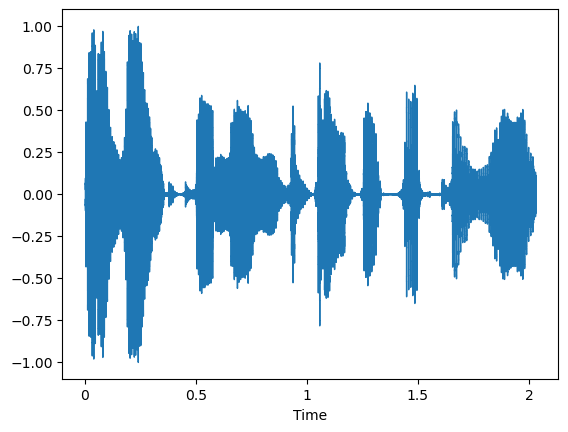

In [187]:
data = os.path.join("./open",X_train_fake["path"][1])
audio,sr = librosa.load(data)
audio = librosa.util.normalize(audio)
audiowgt = Audio(data=audio,rate=sr)
display(audiowgt)
librosa.display.waveshow(audio,sr=sr)

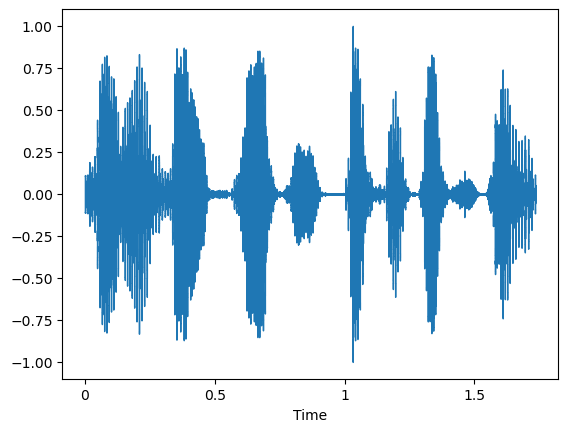

In [189]:
data = os.path.join("./open",X_train_fake["path"][2])
audio,sr = librosa.load(data)
audio = librosa.util.normalize(audio)
audiowgt = Audio(data=audio,rate=sr)
display(audiowgt)
librosa.display.waveshow(audio,sr=sr)

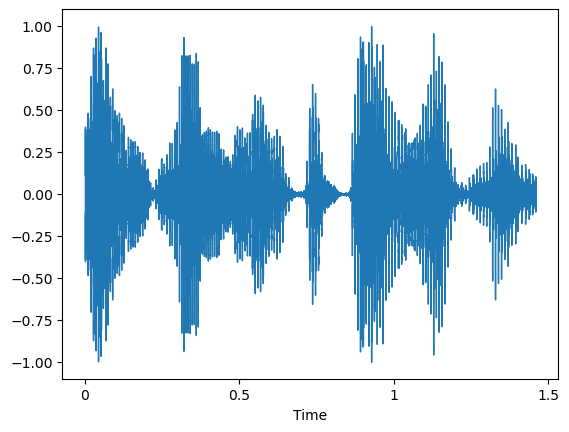

In [191]:
data = os.path.join("./open",X_train_fake["path"][3])
audio,sr = librosa.load(data)
audio = librosa.util.normalize(audio)
audiowgt = Audio(data=audio,rate=sr)
display(audiowgt)
librosa.display.waveshow(audio,sr=sr)

In [12]:
X_train

,id,path,label
26525,VTGZAXKJ,./train/VTGZAXKJ.ogg,real
28922,QLHLSLCS,./train/QLHLSLCS.ogg,fake
23673,YKXZZSVS,./train/YKXZZSVS.ogg,real
18245,CDLVQGDT,./train/CDLVQGDT.ogg,fake
40152,QSHHTXOY,./train/QSHHTXOY.ogg,fake
...,...,...,...
44732,PWTCAYUB,./train/PWTCAYUB.ogg,fake
54343,HSAHCTUQ,./train/HSAHCTUQ.ogg,real
38158,CXJSUSJK,./train/CXJSUSJK.ogg,fake
860,ZBTGTORE,./train/ZBTGTORE.ogg,real


In [8]:
X_train = X_train.reset_index()
X_val = X_val.reset_index()
y_train = y_train.reset_index()
y_val = y_val.reset_index()

In [9]:
X_train

,index,id,path,label
0,26525,VTGZAXKJ,./train/VTGZAXKJ.ogg,real
1,28922,QLHLSLCS,./train/QLHLSLCS.ogg,fake
2,23673,YKXZZSVS,./train/YKXZZSVS.ogg,real
3,18245,CDLVQGDT,./train/CDLVQGDT.ogg,fake
4,40152,QSHHTXOY,./train/QSHHTXOY.ogg,fake
...,...,...,...,...
36029,44732,PWTCAYUB,./train/PWTCAYUB.ogg,fake
36030,54343,HSAHCTUQ,./train/HSAHCTUQ.ogg,real
36031,38158,CXJSUSJK,./train/CXJSUSJK.ogg,fake
36032,860,ZBTGTORE,./train/ZBTGTORE.ogg,real


## 데이터 불러오기

In [10]:
root_dir = "./"

# def add_padding(audio):
#     if len(audio) < CONFIG.PAD_SIZE:
#         audio = np.pad(audio, (0, CONFIG.PAD_SIZE - len(audio)), mode='constant')
#     else:
#         audio = audio[:CONFIG.PAD_SIZE]
#     return audio
def load_audio(df, root_dir):
    audios = []
    for i in tqdm(range(df.shape[0])):
        file_path = os.path.join(root_dir, df["path"][i])
        audio, sample_rate = librosa.load(file_path, sr=Config.SR)
        # audio = add_padding(audio)
        audio_np = np.array(audio)
        audios.append(audio_np)
    return audios

In [11]:
train_audios = load_audio(X_train, root_dir)
train_audios

100%|████████████████████████████████████████████████████████████████████████████| 36034/36034 [10:16<00:00, 58.41it/s]


[array([-0.03493401, -0.04720392, -0.03905734, ...,  0.01794783,
         0.05836653, -0.05124343], dtype=float32),
 array([0.07633661, 0.1311382 , 0.13844413, ..., 0.01983431, 0.02201   ,
        0.02347231], dtype=float32),
 array([ 0.06589692,  0.0761763 ,  0.04328509, ..., -0.04746609,
        -0.05008017, -0.04353867], dtype=float32),
 array([ 0.0687969 ,  0.09404162,  0.0778709 , ..., -0.02310466,
        -0.00310481,  0.01110373], dtype=float32),
 array([-0.05460778, -0.08416761, -0.08133532, ..., -0.07087424,
        -0.07487662, -0.06106302], dtype=float32),
 array([-0.02175857, -0.02967844, -0.02098274, ...,  0.03131709,
         0.03239249,  0.028803  ], dtype=float32),
 array([-0.05140394, -0.05278514, -0.04631227, ..., -0.04852442,
        -0.05393557, -0.04563741], dtype=float32),
 array([-0.02569563, -0.03855547, -0.03831382, ..., -0.04679772,
        -0.05429097, -0.04330054], dtype=float32),
 array([-0.02391773, -0.04191151, -0.05378082, ...,  0.04657521,
         0.05

In [12]:
val_audios = load_audio(X_val, root_dir)
val_audios

100%|████████████████████████████████████████████████████████████████████████████| 19404/19404 [06:43<00:00, 48.13it/s]


[array([-0.03737227, -0.05328577, -0.04432795, ..., -0.07469565,
         0.00280151,  0.05485187], dtype=float32),
 array([ 0.04961466,  0.06770548,  0.04615535, ..., -0.02304168,
        -0.0409341 , -0.03249143], dtype=float32),
 array([ 0.05045838,  0.06760503,  0.05309918, ..., -0.02540854,
        -0.03643021, -0.03837001], dtype=float32),
 array([-0.05353406, -0.08090333, -0.06931115, ...,  0.03473306,
         0.03267439, -0.07167754], dtype=float32),
 array([ 0.01824374,  0.00263109, -0.00052647, ...,  0.00791699,
        -0.02162658, -0.04938579], dtype=float32),
 array([ 0.07024919,  0.09440652,  0.07451238, ..., -0.03311045,
        -0.03645565, -0.03425208], dtype=float32),
 array([-0.05659115, -0.09358966, -0.10386842, ...,  0.01054342,
        -0.0350103 ,  0.04348439], dtype=float32),
 array([ 0.09881341,  0.08199671, -0.11668937, ..., -0.02790711,
         0.00236803,  0.03524268], dtype=float32),
 array([ 0.10107157,  0.14578599,  0.12952627, ..., -0.04657139,
       

In [17]:
def get_mean(data):
    sum=0
    for i in data:
        sum+=len(i)
    return sum/len(data)

In [18]:
train_mean = get_mean(train_audios)
train_mean

68595.21562968308

In [14]:
import numpy as np

def pad_audio(audio, target_length):
    if len(audio) < target_length:
        pad_width = target_length - len(audio)
        left = pad_width // 2
        right = pad_width - left
        padded_audio = np.pad(audio, (left, right), mode='constant')
    else:
        padded_audio = audio[:target_length]
    return padded_audio

target_length = 16000*5
train_audios_padded = [pad_audio(audio, target_length) for audio in train_audios]
val_audios_padded = [pad_audio(audio, target_length) for audio in val_audios]

## Melspectrogram, mfcc

In [15]:
def extract_feature(audios, mfcc=True):
    features = []
    if mfcc: #mfcc로 피처를 추출하고 싶을 때
        for audio in tqdm(audios):
            mfcc_feature = librosa.feature.mfcc(y=audio, sr=CONFIG.SR, n_mfcc=CONFIG.N_MFCC)
            mfcc_feature = np.mean(mfcc_feature.T, axis=0)
            features.append(mfcc_feature)
    else: #mel로 피처 추출하고 싶을 때
        for audio in tqdm(audios):
            mel_feature = librosa.feature.melspectrogram(y=audio, sr=CONFIG.SR, n_mels=CONFIG.N_MELS)
            mel_feature = librosa.power_to_db(mel_feature, ref=np.max)
            features.append(mel_feature)
    return np.array(features)

In [16]:
mfcc_X_train_features = extract_feature(train_audios_padded, mfcc=True)
mfcc_X_val_features = extract_feature(val_audios_padded, mfcc=True)

100%|████████████████████████████████████████████████████████████████████████████| 19404/19404 [12:40<00:00, 25.51it/s]


In [17]:
np.save('./0702/mfcc_X_train_features', mfcc_X_train_features)
np.save('./0702/mfcc_X_val_features', mfcc_X_val_features)

In [18]:
mfcc_X_train_features

array([[-2.28498215e+02,  5.18411674e+01,  2.15411873e+01, ...,
         1.26461506e+00, -1.07576191e-01,  1.29132450e+00],
       [-4.44394409e+02,  4.80738983e+01, -1.38015118e+01, ...,
        -3.20793986e-01, -3.95428836e-01, -9.18091595e-01],
       [-2.23456512e+02,  9.07367935e+01,  1.75330315e+01, ...,
        -4.87885207e-01, -2.45833898e+00, -2.00437456e-01],
       ...,
       [-3.52954865e+02,  5.20684395e+01,  1.14392910e+01, ...,
         1.16817206e-01,  1.03860867e+00,  2.86855906e-01],
       [-2.61748016e+02,  1.14076508e+02, -8.96130943e+00, ...,
        -3.00379336e-01,  4.09081221e-01,  1.38831747e+00],
       [-4.26235626e+02,  2.31165867e+01,  2.19583154e+00, ...,
        -8.25943425e-02, -2.88920254e-01,  8.36134851e-02]], dtype=float32)

In [19]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, Conv2D, MaxPool2D, ZeroPadding2D, BatchNormalization, Input, DepthwiseConv2D, Add, LeakyReLU, ReLU
from tensorflow.keras.optimizers import Adam, SGD

In [20]:
print("mfcc_X_train_features.shape",mfcc_X_train_features.shape)
#((47122, 13)): (샘플 수, mfcc 계수)
print("mfcc_X_val_features.shape",mfcc_X_val_features.shape)

mfcc_X_train_features.shape (36034, 70)
mfcc_X_val_features.shape (19404, 70)


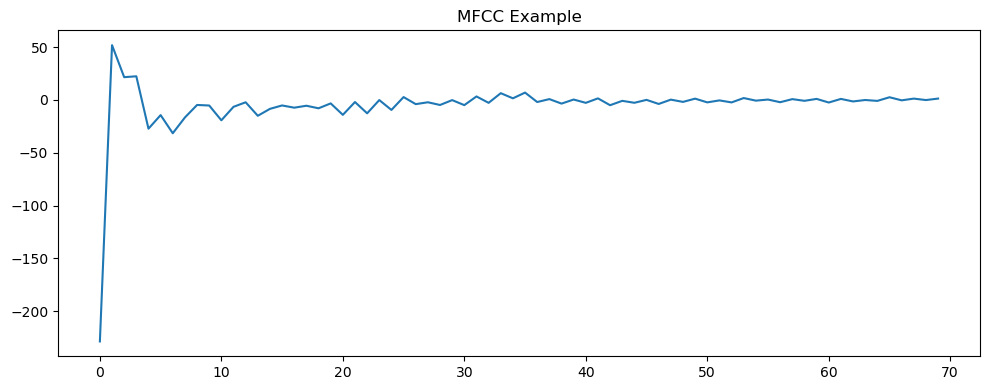

In [21]:
import matplotlib.pyplot as plt

# Mel-spectrogram 시각화
def plot_mel_spectrogram(mel_spectrogram, title='Mel-Spectrogram'):
    plt.figure(figsize=(10, 4))
    plt.imshow(mel_spectrogram, aspect='auto', origin='lower')
    plt.title(title)
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()
    plt.show()

    
# MFCC 시각화
def plot_mfcc(mfcc, title='MFCC'):
    plt.figure(figsize=(10, 4))
    plt.plot(mfcc)
    plt.title(title)
    plt.tight_layout()
    plt.show()

# 예시 Mel-spectrogram 시각화
#plot_mel_spectrogram(mel_X_train_features[0], title='Mel-Spectrogram Example')

# 예시 MFCC 시각화
plot_mfcc(mfcc_X_train_features[0], title='MFCC Example')


### 모델 생성

In [214]:
mel_X_train = np.expand_dims(mel_X_train_features, axis=-1)

In [215]:
mel_X_val = np.expand_dims(mel_X_val_features, axis=-1)

In [22]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

In [23]:
y_train_encoded = pd.get_dummies(data=y_train, columns=["label"], prefix=["labels"], dtype=float)
y_val_encoded = pd.get_dummies(data=y_val, columns=["label"], prefix=["labels"], dtype=float)

In [24]:
y_train_encoded = y_train_encoded[["labels_fake","labels_real"]]
y_val_encoded = y_val_encoded[["labels_fake","labels_real"]]

In [25]:
y_train_encoded.shape, y_val_encoded.shape

((36034, 2), (19404, 2))

In [220]:
# 모델 학습
hist = model.fit(mel_X_train, y_train_encoded, 
                 validation_data=(mel_X_val, y_val_encoded), 
                 epochs=15, batch_size=32, callbacks=[es], verbose=1)

Epoch 1/30
1473/1473 ━━━━━━━━━━━━━━━━━━━━ 653s 441ms/step - accuracy: 0.9450 - loss: 0.1468 - val_accuracy: 0.4876 - val_loss: 4.3945
Epoch 2/30
1473/1473 ━━━━━━━━━━━━━━━━━━━━ 656s 445ms/step - accuracy: 0.9906 - loss: 0.0294 - val_accuracy: 0.5219 - val_loss: 1.4673
Epoch 3/30
1473/1473 ━━━━━━━━━━━━━━━━━━━━ 654s 444ms/step - accuracy: 0.9946 - loss: 0.0174 - val_accuracy: 0.7036 - val_loss: 1.1516
Epoch 4/30
1473/1473 ━━━━━━━━━━━━━━━━━━━━ 658s 446ms/step - accuracy: 0.9959 - loss: 0.0137 - val_accuracy: 0.5170 - val_loss: 2.2320
Epoch 5/30
1473/1473 ━━━━━━━━━━━━━━━━━━━━ 660s 448ms/step - accuracy: 0.9967 - loss: 0.0110 - val_accuracy: 0.8460 - val_loss: 0.3485
Epoch 6/30
1473/1473 ━━━━━━━━━━━━━━━━━━━━ 649s 441ms/step - accuracy: 0.9965 - loss: 0.0110 - val_accuracy: 0.6373 - val_loss: 1.1728
Epoch 7/30
1473/1473 ━━━━━━━━━━━━━━━━━━━━ 650s 441ms/step - accuracy: 0.9975 - loss: 0.0075 - val_accuracy: 0.5871 - val_loss: 1.8302
Epoch 8/30
1473/1473 ━━━━━━━━━━━━━━━━━━━━ 649s 441ms/step - ac

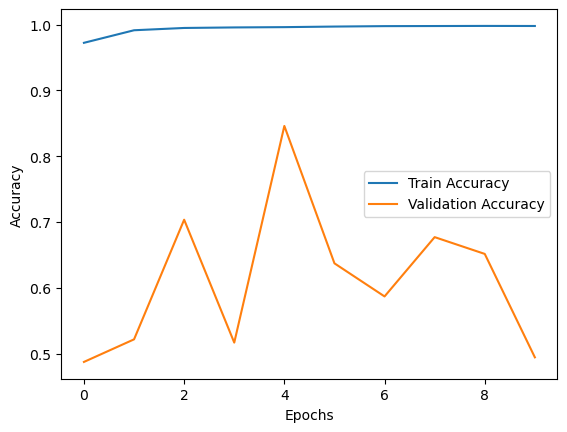

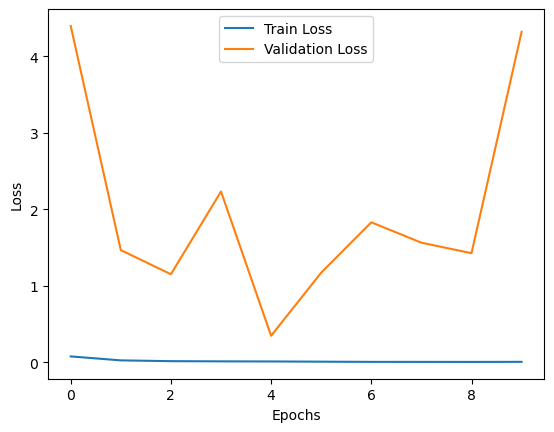

In [221]:
import matplotlib.pyplot as plt

plt.plot(hist.history['accuracy'], label='Train Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(hist.history['loss'], label='Train Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [222]:
from sklearn.metrics import roc_auc_score

def multiLabel_AUC(y_true, y_scores):
    auc_scores = []
    for i in range(y_true.shape[1]):
        auc = roc_auc_score(y_true[:, i], y_scores[:, i])
        auc_scores.append(auc)
    mean_auc_score = np.mean(auc_scores)
    return mean_auc_score

In [223]:
def validation(model, val_features, val_labels, loss_fn):
    val_loss, all_labels, all_probs = [], [], []
    
    for i in tqdm(range(len(val_features))):
        features = val_features[i:i+1]
        labels = val_labels[i:i+1]
        
        # 모델 예측
        probs = model(features, training=False)
        
        # 손실 계산
        loss = loss_fn(labels, probs)
        val_loss.append(loss.numpy())
        
        all_labels.append(labels)
        all_probs.append(probs)
    
    _val_loss = np.mean(val_loss)
    
    all_labels = np.concatenate(all_labels, axis=0)
    all_probs = np.concatenate(all_probs, axis=0)
    
    # AUC 점수 계산
    auc_score = multiLabel_AUC(all_labels, all_probs)
    
    return _val_loss, auc_score

In [225]:
import tensorflow as tf
loss_fn = tf.keras.losses.CategoricalCrossentropy()

val_loss, val_auc = validation(model, mel_X_val, y_val_encoded, loss_fn)
print(f'Validation Loss: {val_loss}, Validation AUC: {val_auc}')

100%|███████████████████████████████████████| 8316/8316 [02:10<00:00, 63.85it/s]

Validation Loss: 4.317596435546875, Validation AUC: 0.9818619596599328


In [227]:
test = pd.read_csv('./open/test.csv')
print(test.head())


test = load_audio(test, root_dir)

test_mel = extract_feature(test, mfcc=False)

test_dataset = tf.data.Dataset.from_tensor_slices(test_mel).batch(CONFIG.BATCH_SIZE)

           id                   path
0  TEST_00000  ./test/TEST_00000.ogg
1  TEST_00001  ./test/TEST_00001.ogg
2  TEST_00002  ./test/TEST_00002.ogg
3  TEST_00003  ./test/TEST_00003.ogg
4  TEST_00004  ./test/TEST_00004.ogg


100%|████████████████████████████████████| 50000/50000 [03:15<00:00, 256.11it/s]


In [44]:
def inference(model, test_dataset):
    predictions = []
    for features in tqdm(test_dataset):
        probs = model(features, training=False)
        predictions.extend(probs.numpy().tolist())
    return predictions

In [229]:
preds = inference(model, test_dataset)

100%|█████████████████████████████████████████| 391/391 [05:11<00:00,  1.26it/s]


In [230]:
submit = pd.read_csv('./open/sample_submission.csv')
submit.iloc[:, 1:] = preds
submit.head()

,id,fake,real
0,TEST_00000,5.022743e-21,1.0
1,TEST_00001,1.232272e-20,1.0
2,TEST_00002,1.268192e-20,1.0
3,TEST_00003,3.370483e-10,1.0
4,TEST_00004,9.664231e-17,1.0


In [231]:
submit.to_csv('./open/result/mel.csv', index=False)

In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, Activation, Bidirectional, LSTM, TimeDistributed, Reshape


def mfcc_cnn_lstm(input_shape, num_classes):
    model = Sequential()

    model.add(Conv1D(32, kernel_size=3, padding='same', input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.8))

    model.add(Conv1D(64, kernel_size=3, padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.8))

    # LSTM 
    # model.add(LSTM(64, return_sequences=True))
    # model.add(LSTM(64))  
    # 결과: 0.39317 -> cnn만을 사용했을 때보다 0.03정도 낮아짐
    
    #LSTM 대신 BiLstm으로 교체해봄 0.3792214873	
    model.add(Bidirectional(LSTM(64, return_sequences=True)))
    model.add(Bidirectional(LSTM(64)))

    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.8))
    model.add(Dense(num_classes, activation='softmax'))

    return model

input_shape_mfcc = (13, 1)  # (timesteps, features)
num_classes = CONFIG.N_CLASSES

model2 = mfcc_cnn_lstm(input_shape_mfcc, num_classes)

model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', patience=15, verbose=1, restore_best_weights=True)

# 데이터 변환 (timesteps, features) 형태로
mfcc_X_train_features_reshaped = mfcc_X_train_features.reshape(mfcc_X_train_features.shape[0], mfcc_X_train_features.shape[1], 1)
mfcc_X_val_features_reshaped = mfcc_X_val_features.reshape(mfcc_X_val_features.shape[0], mfcc_X_val_features.shape[1], 1)

hist = model2.fit(mfcc_X_train_features_reshaped, y_train_encoded, 
                 validation_data=(mfcc_X_val_features_reshaped, y_val_encoded), 
                 epochs=15, batch_size=32, callbacks=[es], verbose=1)


Epoch 1/15
1127/1127 ━━━━━━━━━━━━━━━━━━━━ 526s 455ms/step - accuracy: 0.7826 - loss: 0.4584 - val_accuracy: 0.5627 - val_loss: 0.9714
Epoch 2/15
1127/1127 ━━━━━━━━━━━━━━━━━━━━ 461s 409ms/step - accuracy: 0.8608 - loss: 0.3411 - val_accuracy: 0.7514 - val_loss: 0.4995
Epoch 3/15
1127/1127 ━━━━━━━━━━━━━━━━━━━━ 465s 413ms/step - accuracy: 0.8837 - loss: 0.2850 - val_accuracy: 0.8877 - val_loss: 0.2781
Epoch 4/15
1127/1127 ━━━━━━━━━━━━━━━━━━━━ 439s 390ms/step - accuracy: 0.8984 - loss: 0.2479 - val_accuracy: 0.8610 - val_loss: 0.2916
Epoch 5/15
1127/1127 ━━━━━━━━━━━━━━━━━━━━ 462s 410ms/step - accuracy: 0.9071 - loss: 0.2346 - val_accuracy: 0.8424 - val_loss: 0.3309
Epoch 6/15
1127/1127 ━━━━━━━━━━━━━━━━━━━━ 464s 412ms/step - accuracy: 0.9120 - loss: 0.2271 - val_accuracy: 0.8261 - val_loss: 0.3877
Epoch 7/15
1127/1127 ━━━━━━━━━━━━━━━━━━━━ 458s 406ms/step - accuracy: 0.9186 - loss: 0.2117 - val_accuracy: 0.8668 - val_loss: 0.2967
Epoch 8/15
1127/1127 ━━━━━━━━━━━━━━━━━━━━ 456s 405ms/step - ac

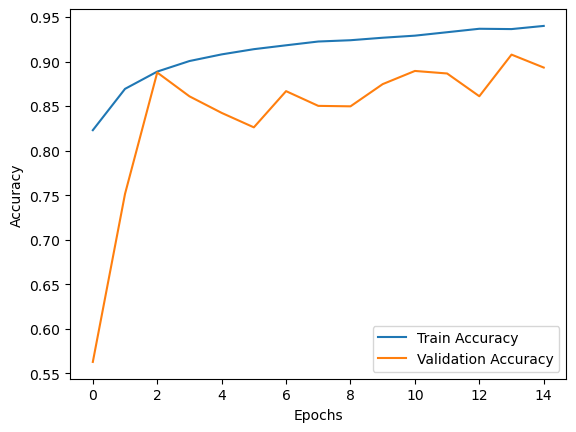

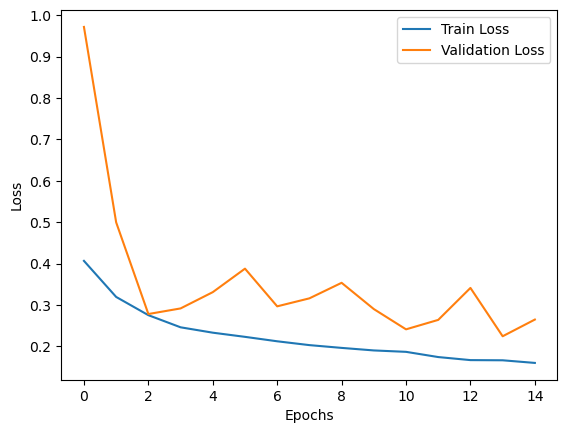

In [39]:
import matplotlib.pyplot as plt

plt.plot(hist.history['accuracy'], label='Train Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(hist.history['loss'], label='Train Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [263]:
val_loss, val_auc = validation(model2, mfcc_X_val_features_reshaped, y_val_encoded, loss_fn)
print(f'Validation Loss: {val_loss}, Validation AUC: {val_auc}')

100%|███████████████████████████████████████| 8316/8316 [03:45<00:00, 36.92it/s]


Validation Loss: 0.3921849727630615, Validation AUC: 0.9120785225213859


In [40]:
test = pd.read_csv('./test.csv')
print(test.head())

test = load_audio(test, root_dir)

test_mfcc = extract_feature(test, mfcc=True)

           id                   path
0  TEST_00000  ./test/TEST_00000.ogg
1  TEST_00001  ./test/TEST_00001.ogg
2  TEST_00002  ./test/TEST_00002.ogg
3  TEST_00003  ./test/TEST_00003.ogg
4  TEST_00004  ./test/TEST_00004.ogg


100%|████████████████████████████████████████████████████████████████████████████| 50000/50000 [30:48<00:00, 27.05it/s]


In [42]:
import tensorflow as tf

test_dataset = tf.data.Dataset.from_tensor_slices(test_mfcc).batch(CONFIG.BATCH_SIZE)

In [45]:
preds = inference(model2, test_dataset)

100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [11:42<00:00,  2.23it/s]


In [46]:
submit = pd.read_csv('./sample_submission.csv')
submit.iloc[:, 1:] = preds
submit.head()

,id,fake,real
0,TEST_00000,0.087060,0.912940
1,TEST_00001,0.027700,0.972300
2,TEST_00002,0.054461,0.945539
3,TEST_00003,0.280951,0.719049
4,TEST_00004,0.007115,0.992885


In [47]:
submit.to_csv('./mfcc_bilstm_2.csv', index=False)

In [280]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Activation, concatenate, GlobalAveragePooling1D, Dense, MaxPooling1D, Dropout, Bidirectional, LSTM
from tensorflow.keras.callbacks import EarlyStopping

def inception_module(x, filters):
    conv1 = Conv1D(filters, 1, padding='same', activation='relu')(x)
    conv3 = Conv1D(filters, 3, padding='same', activation='relu')(x)
    conv5 = Conv1D(filters, 5, padding='same', activation='relu')(x)
    pool = MaxPooling1D(pool_size=3, strides=1, padding='same')(x)
    pool_conv = Conv1D(filters, 1, padding='same', activation='relu')(pool)
    return concatenate([conv1, conv3, conv5, pool_conv], axis=-1)

def cnn_inception_rnn(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    
    x = Conv1D(32, kernel_size=3, kernel_initializer='he_uniform', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.5)(x)
    
    x = Conv1D(64, kernel_size=3, kernel_initializer='he_uniform', padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.5)(x)
    
    x = inception_module(x, 64) # inception module 추가
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = inception_module(x, 128) # inception module 추가
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Bidirectional(LSTM(64, return_sequences=True))(x)
    x = Dropout(0.8)(x)
    x = Bidirectional(LSTM(64))(x)
    x = Dropout(0.8)(x)
    
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.58)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

input_shape_mfcc = (13, 1)
num_classes = CONFIG.N_CLASSES
model = cnn_inception_rnn(input_shape_mfcc, num_classes)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

mfcc_X_train_features_reshaped = mfcc_X_train_features.reshape(mfcc_X_train_features.shape[0], mfcc_X_train_features.shape[1], 1)
mfcc_X_val_features_reshaped = mfcc_X_val_features.reshape(mfcc_X_val_features.shape[0], mfcc_X_val_features.shape[1], 1)

es = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
hist = model.fit(mfcc_X_train_features_reshaped, y_train_encoded, 
                 validation_data=(mfcc_X_val_features_reshaped, y_val_encoded), 
                 epochs=15, batch_size=32, callbacks=[es], verbose=1)


Model: "functional_220"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 13, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_30 (Conv1D)  │ (None, 13, 32)    │        128 │ input_layer_12[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 13, 32)    │        128 │ conv1d_30[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_48       │ (None, 13, 32)    │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_30    │ (None, 6, 32)     │          0 │ activation_48[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_47          │ (None, 6, 32)     │          0 │ max_pooling1d_30… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_31 (Conv1D)  │ (None, 6, 64)     │      6,208 │ dropout_47[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 6, 64)     │        256 │ conv1d_31[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_49       │ (None, 6, 64)     │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_31    │ (None, 3, 64)     │          0 │ activation_49[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_48          │ (None, 3, 64)     │          0 │ max_pooling1d_31… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_32    │ (None, 3, 64)     │          0 │ dropout_48[0][0]  │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_32 (Conv1D)  │ (None, 3, 64)     │      4,160 │ dropout_48[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_33 (Conv1D)  │ (None, 3, 64)     │     12,352 │ dropout_48[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_34 (Conv1D)  │ (None, 3, 64)     │     20,544 │ dropout_48[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_35 (Conv1D)  │ (None, 3, 64)     │      4,160 │ max_pooling1d_32… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 3, 256)    │          0 │ conv1d_32[0][0],  │
│ (Concatenate)       │                   │            │ conv1d_33[0][0],  │
│                     │                   │            │ conv1d_34[0][0],  │
│                     │                   │            │ conv1d_35[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 3, 256)    │      1,024 │ concatenate[0][0] │
│ (BatchNormalizatio… │                   │            │                 

 Total params: 790,210 (3.01 MB)

 Trainable params: 788,482 (3.01 MB)

 Non-trainable params: 1,728 (6.75 KB)

Epoch 1/100
1473/1473 ━━━━━━━━━━━━━━━━━━━━ 26s 15ms/step - accuracy: 0.7751 - loss: 0.4963 - val_accuracy: 0.8347 - val_loss: 0.4165
Epoch 2/100
1473/1473 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.8392 - loss: 0.3899 - val_accuracy: 0.8628 - val_loss: 0.3356
Epoch 3/100
1473/1473 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.8455 - loss: 0.3717 - val_accuracy: 0.8789 - val_loss: 0.3006
Epoch 4/100
1473/1473 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.8492 - loss: 0.3626 - val_accuracy: 0.8801 - val_loss: 0.3013
Epoch 5/100
1473/1473 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.8563 - loss: 0.3536 - val_accuracy: 0.8835 - val_loss: 0.2984
Epoch 6/100
1473/1473 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.8592 - loss: 0.3435 - val_accuracy: 0.8521 - val_loss: 0.3165
Epoch 7/100
1473/1473 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.8586 - loss: 0.3390 - val_accuracy: 0.8844 - val_loss: 0.2869
Epoch 8/100
1473/1473 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 

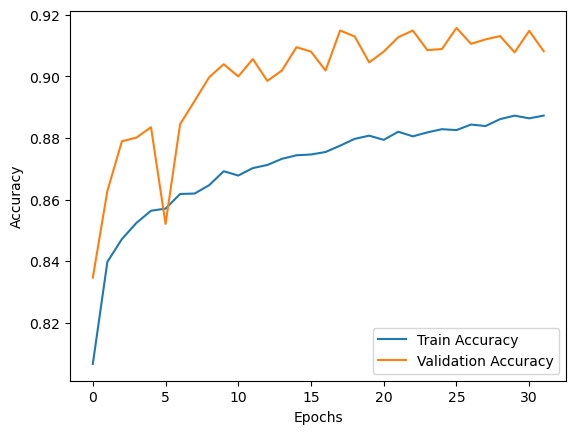

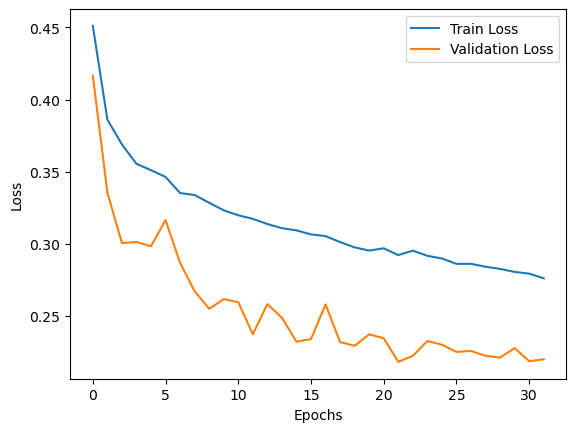

In [282]:
import matplotlib.pyplot as plt

plt.plot(hist.history['accuracy'], label='Train Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(hist.history['loss'], label='Train Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [284]:
val_loss, val_auc = validation(model, mfcc_X_val_features_reshaped, y_val_encoded, loss_fn)
print(f'Validation Loss: {val_loss}, Validation AUC: {val_auc}')

100%|███████████████████████████████████████| 8316/8316 [04:09<00:00, 33.39it/s]


Validation Loss: 0.21824081242084503, Validation AUC: 0.9725206479436266


In [285]:
preds = inference(model, test_dataset)

100%|█████████████████████████████████████████| 391/391 [00:14<00:00, 26.10it/s]


In [286]:
submit = pd.read_csv('./open/sample_submission.csv')
submit.iloc[:, 1:] = preds
submit.head()

,id,fake,real
0,TEST_00000,0.074158,0.925842
1,TEST_00001,0.010497,0.989503
2,TEST_00002,0.113986,0.886014
3,TEST_00003,0.871628,0.128372
4,TEST_00004,0.198048,0.801952


In [287]:
submit.to_csv('./open/result/mfcc_inception.csv', index=False) # 0.3992222563